In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from datetime import timedelta
import altair as alt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.offsets import MonthEnd
# Set plotting style
sns.set(style='whitegrid')

In [2]:
# Load the data from the text file
data = pd.read_csv('data/raw/PET/PET.txt', sep='\t', header=None, names=['json_str'])

# Function to parse JSON strings
def parse_json_str(json_str):
    return json.loads(json_str)

# Apply the function to parse the JSON strings
parsed_data = data['json_str'].apply(parse_json_str)

# Create a DataFrame from the parsed JSON data
df = pd.json_normalize(parsed_data)

# Display the first few rows of the DataFrame
print(df.head())

                       series_id  \
0  PET.EMM_EPMPR_PTE_Y35NY_DPG.W   
1  PET.EMM_EPMPR_PTE_Y44HO_DPG.W   
2  PET.EMM_EPMMR_PTE_R5XCA_DPG.W   
3  PET.EMM_EPMMR_PTE_Y05LA_DPG.W   
4  PET.EMM_EPMMR_PTE_Y05SF_DPG.W   

                                                name               units  f  \
0  New York Harbor Premium Reformulated Retail Ga...  Dollars per Gallon  W   
1  Houston, TX Premium Reformulated Retail Gasoli...  Dollars per Gallon  W   
2  West Coast (PADD 5) Except California Midgrade...  Dollars per Gallon  W   
3  Los Angeles, CA Midgrade Reformulated Retail G...  Dollars per Gallon  W   
4  San Francisco, CA Midgrade Reformulated Retail...  Dollars per Gallon  W   

  unitsshort                                        description copyright  \
0      $/gal  New York Harbor Premium Reformulated Retail Ga...      None   
1      $/gal  Houston, TX Premium Reformulated Retail Gasoli...      None   
2      $/gal  West Coast (PADD 5) Except California Midgrade...      None   


In [3]:
df.columns

Index(['series_id', 'name', 'units', 'f', 'unitsshort', 'description',
       'copyright', 'source', 'iso3166', 'geography', 'start', 'end',
       'last_updated', 'data', 'geography2', 'category_id',
       'parent_category_id', 'notes', 'childseries'],
      dtype='object')

In [4]:
# Explode the 'data' column to separate rows for each date-value pair
df = df.explode('data')
df.head()

,series_id,name,units,f,unitsshort,description,copyright,source,iso3166,geography,start,end,last_updated,data,geography2,category_id,parent_category_id,notes,childseries
0,PET.EMM_EPMPR_PTE_Y35NY_DPG.W,New York Harbor Premium Reformulated Retail Ga...,Dollars per Gallon,W,$/gal,New York Harbor Premium Reformulated Retail Ga...,None,"EIA, U.S. Energy Information Administration",USA-NY,USA-NY,20000605,20240617,2024-06-17T22:10:18-04:00,"[20240617, 4.306]",NaN,NaN,NaN,NaN,NaN
0,PET.EMM_EPMPR_PTE_Y35NY_DPG.W,New York Harbor Premium Reformulated Retail Ga...,Dollars per Gallon,W,$/gal,New York Harbor Premium Reformulated Retail Ga...,None,"EIA, U.S. Energy Information Administration",USA-NY,USA-NY,20000605,20240617,2024-06-17T22:10:18-04:00,"[20240610, 4.328]",NaN,NaN,NaN,NaN,NaN
0,PET.EMM_EPMPR_PTE_Y35NY_DPG.W,New York Harbor Premium Reformulated Retail Ga...,Dollars per Gallon,W,$/gal,New York Harbor Premium Reformulated Retail Ga...,None,"EIA, U.S. Energy Information Administration",USA-NY,USA-NY,20000605,20240617,2024-06-17T22:10:18-04:00,"[20240603, 4.367]",NaN,NaN,NaN,NaN,NaN
0,PET.EMM_EPMPR_PTE_Y35NY_DPG.W,New York Harbor Premium Reformulated Retail Ga...,Dollars per Gallon,W,$/gal,New York Harbor Premium Reformulated Retail Ga...,None,"EIA, U.S. Energy Information Administration",USA-NY,USA-NY,20000605,20240617,2024-06-17T22:10:18-04:00,"[20240527, 4.412]",NaN,NaN,NaN,NaN,NaN
0,PET.EMM_EPMPR_PTE_Y35NY_DPG.W,New York Harbor Premium Reformulated Retail Ga...,Dollars per Gallon,W,$/gal,New York Harbor Premium Reformulated Retail Ga...,None,"EIA, U.S. Energy Information Administration",USA-NY,USA-NY,20000605,20240617,2024-06-17T22:10:18-04:00,"[20240520, 4.399]",NaN,NaN,NaN,NaN,NaN


In [5]:
# Select distinct series_id, name, units
df_series = df[['series_id', 'name', 'units']].drop_duplicates()
df_series.head()

,series_id,name,units
0,PET.EMM_EPMPR_PTE_Y35NY_DPG.W,New York Harbor Premium Reformulated Retail Ga...,Dollars per Gallon
1,PET.EMM_EPMPR_PTE_Y44HO_DPG.W,"Houston, TX Premium Reformulated Retail Gasoli...",Dollars per Gallon
2,PET.EMM_EPMMR_PTE_R5XCA_DPG.W,West Coast (PADD 5) Except California Midgrade...,Dollars per Gallon
3,PET.EMM_EPMMR_PTE_Y05LA_DPG.W,"Los Angeles, CA Midgrade Reformulated Retail G...",Dollars per Gallon
4,PET.EMM_EPMMR_PTE_Y05SF_DPG.W,"San Francisco, CA Midgrade Reformulated Retail...",Dollars per Gallon


In [6]:
# Return a count of the number of records by units 
df_series['units'].value_counts()

units
Thousand Barrels                     68599
Thousand Barrels per Day             67817
Dollars per Gallon                   17835
Thousand Gallons per Day             11784
Thousand Gallons                      6001
Barrels per Stream Day                1960
Million Barrels                       1261
Percent                                623
Barrels per Calendar Day               343
Dollars per Barrel                     304
Number of Elements                     287
Billion Cubic Feet                     168
Million Gallons                        117
Million Cubic Feet per Day              49
Short Tons per Day                      49
Thousand Barrels per Calendar Day       44
Thouand Barrels per Day                 32
Degree                                  32
Million Cubic Feet                      16
Thousand Feet                           14
Feet per Well                           12
Million Pounds                           7
Million Kilowatthours                    7
Thous

In [7]:
# Filter df to only include name containing 'Louisiana' and units in Dollars per Gallon
df_louisiana = df[df['name'].str.contains('Louisiana Total') & df['units'].str.contains('Dollars per Gallon')]
df_louisiana

,series_id,name,units,f,unitsshort,description,copyright,source,iso3166,geography,start,end,last_updated,data,geography2,category_id,parent_category_id,notes,childseries
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,198301,202203,2022-06-01T10:50:11-04:00,"[202203, 3.09]",NaN,NaN,NaN,NaN,NaN
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,198301,202203,2022-06-01T10:50:11-04:00,"[202202, 2.598]",NaN,NaN,NaN,NaN,NaN
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,198301,202203,2022-06-01T10:50:11-04:00,"[202201, 2.331]",NaN,NaN,NaN,NaN,NaN
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,198301,202203,2022-06-01T10:50:11-04:00,"[202112, 2.191]",NaN,NaN,NaN,NaN,NaN
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,198301,202203,2022-06-01T10:50:11-04:00,"[202111, 2.332]",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,1984,2021,2022-04-01T10:51:55-04:00,"[1988, 0.552]",NaN,NaN,NaN,NaN,NaN
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,1984,2021,2022-04-01T10:51:55-04:00,"[1987, 0.566]",NaN,NaN,NaN,NaN,NaN
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,1984,2021,2022-04-01T10:51:55-04:00,"[1986, 0.511]",NaN,NaN,NaN,NaN,NaN
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,1984,2021,2022-04-01T10:51:55-04:00,"[1985, 0.832]",NaN,NaN,NaN,NaN,NaN


In [8]:
# Drop rows where 'data' is NaN or not a list
df_louisiana = df_louisiana.dropna(subset=['data'])
df_louisiana = df_louisiana[df_louisiana['data'].apply(lambda x: isinstance(x, list) and len(x) == 2)]
df_louisiana.head()

,series_id,name,units,f,unitsshort,description,copyright,source,iso3166,geography,start,end,last_updated,data,geography2,category_id,parent_category_id,notes,childseries
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,198301,202203,2022-06-01T10:50:11-04:00,"[202203, 3.09]",NaN,NaN,NaN,NaN,NaN
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,198301,202203,2022-06-01T10:50:11-04:00,"[202202, 2.598]",NaN,NaN,NaN,NaN,NaN
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,198301,202203,2022-06-01T10:50:11-04:00,"[202201, 2.331]",NaN,NaN,NaN,NaN,NaN
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,198301,202203,2022-06-01T10:50:11-04:00,"[202112, 2.191]",NaN,NaN,NaN,NaN,NaN
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,198301,202203,2022-06-01T10:50:11-04:00,"[202111, 2.332]",NaN,NaN,NaN,NaN,NaN


In [9]:
# Split 'data' column into 'date' and 'value'
df_louisiana[['date', 'value']] = pd.DataFrame(df_louisiana['data'].tolist(), index=df_louisiana.index)
df_louisiana

,series_id,name,units,f,unitsshort,description,copyright,source,iso3166,geography,...,end,last_updated,data,geography2,category_id,parent_category_id,notes,childseries,date,value
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,202203,2022-06-01T10:50:11-04:00,"[202203, 3.09]",NaN,NaN,NaN,NaN,NaN,202203,3.090
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,202203,2022-06-01T10:50:11-04:00,"[202202, 2.598]",NaN,NaN,NaN,NaN,NaN,202202,2.598
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,202203,2022-06-01T10:50:11-04:00,"[202201, 2.331]",NaN,NaN,NaN,NaN,NaN,202201,2.331
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,202203,2022-06-01T10:50:11-04:00,"[202112, 2.191]",NaN,NaN,NaN,NaN,NaN,202112,2.191
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,202203,2022-06-01T10:50:11-04:00,"[202111, 2.332]",NaN,NaN,NaN,NaN,NaN,202111,2.332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,2021,2022-04-01T10:51:55-04:00,"[1988, 0.552]",NaN,NaN,NaN,NaN,NaN,1988,0.552
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,2021,2022-04-01T10:51:55-04:00,"[1987, 0.566]",NaN,NaN,NaN,NaN,NaN,1987,0.566
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,2021,2022-04-01T10:51:55-04:00,"[1986, 0.511]",NaN,NaN,NaN,NaN,NaN,1986,0.511
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,2021,2022-04-01T10:51:55-04:00,"[1985, 0.832]",NaN,NaN,NaN,NaN,NaN,1985,0.832


In [10]:
# Convert 'date' to datetime, coercing errors to NaT
df_louisiana['date'] = pd.to_datetime(df_louisiana['date'], format='%Y%m%d', errors='coerce')
# Convert 'value' to a numeric type, coercing errors to NaN
df_louisiana['value'] = pd.to_numeric(df_louisiana['value'], errors='coerce')
df_louisiana

,series_id,name,units,f,unitsshort,description,copyright,source,iso3166,geography,...,end,last_updated,data,geography2,category_id,parent_category_id,notes,childseries,date,value
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,202203,2022-06-01T10:50:11-04:00,"[202203, 3.09]",NaN,NaN,NaN,NaN,NaN,NaT,3.090
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,202203,2022-06-01T10:50:11-04:00,"[202202, 2.598]",NaN,NaN,NaN,NaN,NaN,NaT,2.598
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,202203,2022-06-01T10:50:11-04:00,"[202201, 2.331]",NaN,NaN,NaN,NaN,NaN,NaT,2.331
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,202203,2022-06-01T10:50:11-04:00,"[202112, 2.191]",NaN,NaN,NaN,NaN,NaN,2021-01-02,2.191
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,202203,2022-06-01T10:50:11-04:00,"[202111, 2.332]",NaN,NaN,NaN,NaN,NaN,2021-01-01,2.332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,2021,2022-04-01T10:51:55-04:00,"[1988, 0.552]",NaN,NaN,NaN,NaN,NaN,NaT,0.552
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,2021,2022-04-01T10:51:55-04:00,"[1987, 0.566]",NaN,NaN,NaN,NaN,NaN,NaT,0.566
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,2021,2022-04-01T10:51:55-04:00,"[1986, 0.511]",NaN,NaN,NaN,NaN,NaN,NaT,0.511
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,2021,2022-04-01T10:51:55-04:00,"[1985, 0.832]",NaN,NaN,NaN,NaN,NaN,NaT,0.832


In [11]:
# Extract relevant columns and preprocess the data
df_louisiana['Date'] = pd.to_datetime(df_louisiana['date'])
df_louisiana['Price'] = df_louisiana['value']
df_louisiana = df_louisiana[['Date', 'Price']].sort_values(by='Date').reset_index(drop=True)
df_louisiana.tail()

,Date,Price
4145,NaT,0.552
4146,NaT,0.566
4147,NaT,0.511
4148,NaT,0.832
4149,NaT,0.841


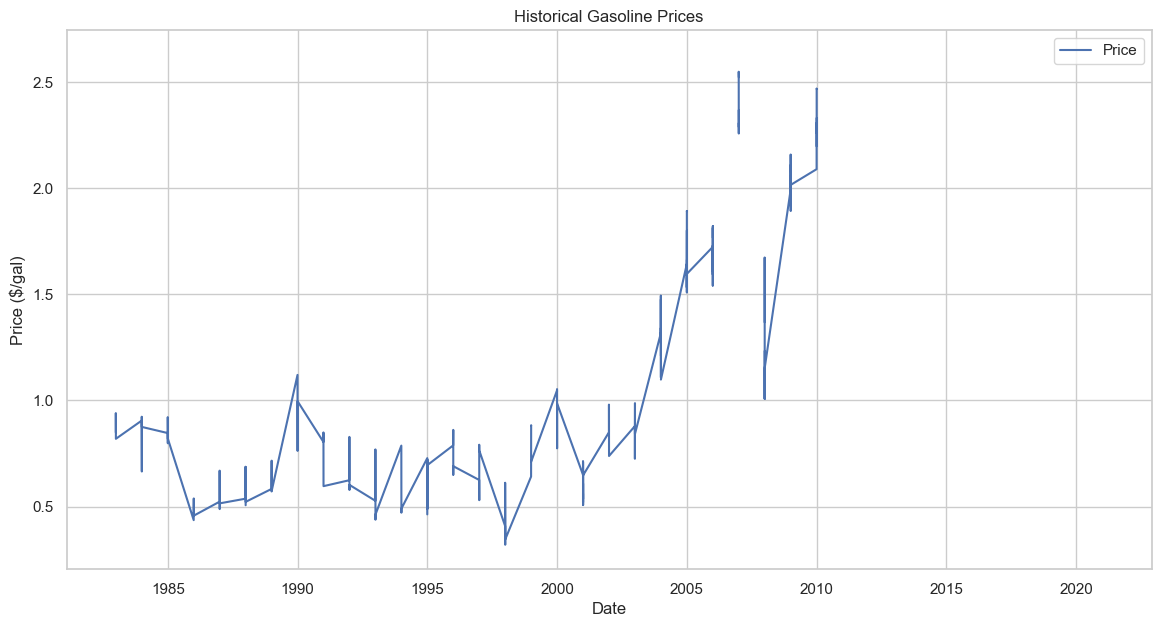

In [12]:
# Plot historical prices
plt.figure(figsize=(14, 7))
plt.plot(df_louisiana['Date'], df_louisiana['Price'], label='Price')
plt.title('Historical Gasoline Prices')
plt.xlabel('Date')
plt.ylabel('Price ($/gal)')
plt.legend()
plt.grid(True)
plt.show()

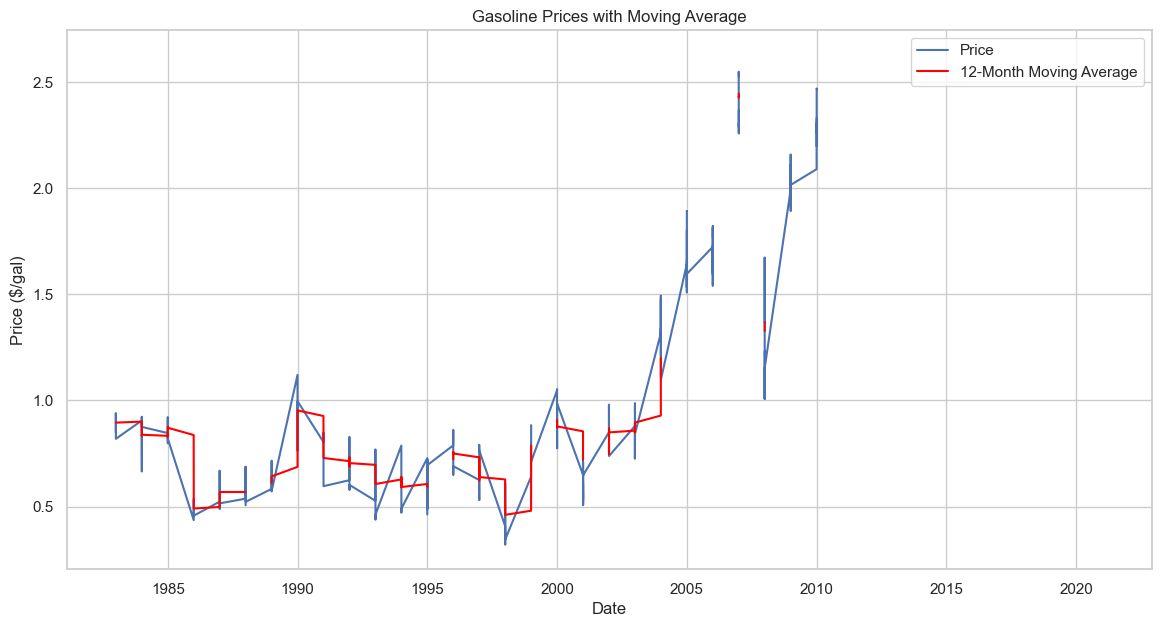

In [13]:
# Moving Average
df_louisiana['Price_MA'] = df_louisiana['Price'].rolling(window=12).mean()

plt.figure(figsize=(14, 7))
plt.plot(df_louisiana['Date'], df_louisiana['Price'], label='Price')
plt.plot(df_louisiana['Date'], df_louisiana['Price_MA'], label='12-Month Moving Average', color='red')
plt.title('Gasoline Prices with Moving Average')
plt.xlabel('Date')
plt.ylabel('Price ($/gal)')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Load and prepare the dataset
def load_gas_price_data():
    df = pd.read_csv('data\processed\louisiana_tot_gasoline_wholesale_monthly.csv')
    df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Convert 'date' to datetime, coercing errors
    df = df[['date', 'value']].dropna()  # Keep only necessary columns and drop NA values
    return df

# Prepare data for long format and additional transformations
def prepare_data(df):
    df = df.sort_values('date')
    df['log_price'] = np.log(df['value'])
    df['price_change'] = df['log_price'].diff()
    return df

# Function to perform AutoARIMA forecasting
def forecast_prices(df, cutoff_date):
    # Filter the DataFrame based on the cutoff date
    df_filtered = df[df['date'] < pd.to_datetime(cutoff_date)]
    
    # Convert prices to log prices to stabilize variance
    df_filtered['log_price'] = np.log(df_filtered['price'])
    
    # Define the model
    model = SARIMAX(df_filtered['log_price'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    
    # Fit the model
    results = model.fit()
    
    # Generate future dates
    future_dates = pd.date_range(df_filtered['date'].max() + MonthEnd(1), periods=13, freq='M')
    
    # Forecast future log prices
    forecast_log_prices = results.forecast(steps=13)
    
    # Convert log prices back to regular prices
    forecast_prices = np.exp(forecast_log_prices)
    
    # Create a DataFrame for the forecasted prices
    forecast_df = pd.DataFrame({
        'date': future_dates,
        'forecast_price': forecast_prices
    })
    
    return forecast_df

# Visualization function
def plot_forecast(df, forecast_df):
    base = alt.Chart(df).encode(
        x='date:T',
        y='value:Q'
    ).properties(
        width=600,
        height=300
    )

    line = base.mark_line(color='blue', size=3)
    points = base.mark_point(color='red')

    forecast_chart = alt.Chart(forecast_df).mark_line(color='green').encode(
        x='date:T',
        y='forecast_price:Q'
    )

    return line + points + forecast_chart

In [15]:
df = load_gas_price_data()
df

,date,value
3,2021-01-02,2.191
4,2021-01-01,2.332
15,2020-01-02,1.307
16,2020-01-01,1.175
27,2019-01-02,1.636
...,...,...
3801,1985-01-01,0.846
3812,1984-01-02,0.787
3813,1984-01-01,0.816
3824,1983-01-02,0.819


In [16]:
df_prepared = prepare_data(df)
df_prepared

,date,value,log_price,price_change
3825,1983-01-01,0.849,-0.163696,NaN
460,1983-01-01,0.849,-0.163696,0.000000
2551,1983-01-01,0.898,-0.107585,0.056111
931,1983-01-01,0.940,-0.061875,0.045710
1402,1983-01-01,0.940,-0.061875,0.000000
...,...,...,...,...
27,2019-01-02,1.636,0.492254,0.003674
16,2020-01-01,1.175,0.161268,-0.330986
15,2020-01-02,1.307,0.267734,0.106466
4,2021-01-01,2.332,0.846726,0.578992


In [17]:
# # Save the model
# import joblib
# joblib.dump(model, 'models/oil_price_forecast_model.pkl')